Sound Similarity using Locality Sensitive Hashing (SimHash)

Author: Lukka Wolff

Professor: Teal Witter

Course: CSCI 1052: Randomized Algorithms for Data Science

Date: 02/02/2024

In [1]:
import math
import os
import librosa
import numpy as np
from scipy.signal import find_peaks
from IPython.display import Audio
import hashlib
import matplotlib.pyplot as plt

In [2]:
# Optimization of r (bands) and t (tables) values for the given upper and lower bounds (based on historgram)

upperbound = 0.5
lowerbound = 0.3
U_theta = math.acos(upperbound)
L_theta = math.acos(lowerbound)

def find_r_by_t(U_theta, L_theta):
    for t in range(1,1000001):
        r = math.floor( math.log((1 - ((1/10) ** (1/t))), (1 - (U_theta / math.pi))) ) 
        if (1 - ((1 - (L_theta ** r)) ** t)) <= 0.1:
            print(f"Bands: {r}\nTables: {t}\n")
            break


find_r_by_t(U_theta, L_theta)

Bands: 3
Tables: 8



In [3]:
tables = 8 # number of tables
bands = 3 # number of bands (r)
integer_list = list(range(tables))
m = 50000 # number of sounds (buckets)


def create_fingerprint(audio_file):
    """Makes binary vector fingerprint from audio file"""

    # Load the audio file
    audio, sr = librosa.load(audio_file, sr=None)

    # Pad the audio signal if necessary
    if len(audio) < 2048:
        audio = np.pad(audio, (0, 2048 - len(audio)))

    # Compute the spectrogram
    spectrogram = np.abs(librosa.stft(audio))

    # Initialize an empty list to store the peaks
    peaks = []

    # Find the peaks in each row of the spectrogram
    for row in spectrogram:
        peaks_row, _ = find_peaks(row)
        peaks.append(peaks_row)

    # Convert the peaks to a binary vector
    fingerprint = np.zeros_like(spectrogram)
    for i, peaks_row in enumerate(peaks):
        fingerprint[i, peaks_row] = 1

    # Flatten the binary vector
    fingerprint = fingerprint.flatten()

    # Pad the fingerprint with zeros if necessary
    if len(fingerprint) < 75000:
        fingerprint = np.pad(fingerprint, (0, 75000 - len(fingerprint)))
    if len(fingerprint) > 75000:
        fingerprint = fingerprint[:75000]

    return fingerprint



In [4]:
def get_binary_vectors(directory):
    # Initialize an empty dictionary to store the binary vectors
    binary_vec_dict = {}

    for dirpath, dirnames, filenames in os.walk(directory):
        # Iterate over the list of files
        for file in filenames:
            # Create the binary vector
            if file.endswith(".wav") or file.endswith(".mp3"):
                audio_path = os.path.join(dirpath, file)
                binary_vec = create_fingerprint(audio_path)

                binary_vec_dict[file] = binary_vec

    return binary_vec_dict



In [5]:
def hash_tuple_with_seed(tuple_object, m, seed):
  """
  Hashes a tuple object to an integer between 1 and m using a seed. TABLE - T

  Args:
    tuple_object: The tuple object to hash.
    m: The upper bound of the hash value (inclusive).
    seed: The seed for the hash function.

  Returns:
    An integer between 1 and m.
  """

  # Convert the tuple object to a string.
  tuple_string = str(tuple_object)

  # Create a hash object with the specified seed.
  hash_object = hashlib.sha256(str(seed).encode('utf-8'))

  # Update the hash object with the tuple string.
  hash_object.update(tuple_string.encode('utf-8'))

  # Get the hash value as a hexadecimal string.
  hash_value = hash_object.hexdigest()

  # Convert the hexadecimal string to an integer.
  hash_value_int = int(hash_value, 16)

  # Return the hash value modulo m.
  return hash_value_int % m + 1



In [6]:
# Create dataset of binary vectors

#directory = "C:/Users/lukka/OneDrive/Desktop/J-Term 3/FINAL/small pack with duplicates"
directory = "C:/Users/lukka/OneDrive/Desktop/FL Packs/@kyd.and.cambria - YeatxKanKan DrumxLoopKit"
#directory = "C:/Users/lukka/OneDrive/Desktop/FL Packs/TriSamples - 808 Trapstep Pack Vol 2"
binary_vec_dict = get_binary_vectors(directory)

In [7]:
# Convert binary vector dictionary into two separate lists (to be improved)

binary_vec_list = []
sound_name_list = []
for name, vec in binary_vec_dict.items():
    binary_vec_list.append(vec)
    sound_name_list.append(name)


In [8]:
# SimHash Matrix function

d = 75000 # length of binary vector
Gs = {}
# creates Gs matrix to speed up making the SimHash tuple
for t_idx in integer_list:
    np.random.seed(t_idx)
    Gs[t_idx] = np.random.normal(size=(d, bands))


In [9]:
# Create Hash Table

hash_table = {}
for i in range(tables):
    hash_table[i] = {}
    
# Fill the hash tables / buckets with vectors indeces to be able to search for similar sounds

for vec_idx, binary_vec in enumerate(binary_vec_dict.values()):
    for t_idx in integer_list:
        simhash_tuple = np.sign(binary_vec @ Gs[t_idx])
        bucket = hash_tuple_with_seed(simhash_tuple, m, t_idx)
        if bucket not in hash_table[t_idx]:
            hash_table[t_idx][bucket] = []
        hash_table[t_idx][bucket].append(vec_idx)

In [10]:
# Look at cool tables :)

for i in range(tables):
    print(hash_table[i])

{2442: [0, 1, 2, 3, 6, 8, 9, 11, 13, 16, 17, 20, 21, 24, 25, 30, 31, 32, 47, 52, 56, 68, 71, 78, 79, 84, 90, 91, 92, 94, 95, 97, 100, 105, 107, 108, 109, 115, 116, 118, 122, 144, 146, 153, 156, 159], 34494: [4, 10, 15, 18, 22, 23, 34, 44, 46, 48, 49, 50, 62, 70, 75, 76, 77, 83, 85, 89, 93, 102, 103, 106, 112, 117, 128, 142, 148, 152, 158], 9795: [5, 12, 27, 28, 40, 42, 45, 59, 63, 66, 80, 86, 87, 114, 129, 132, 135, 141, 150, 151], 35384: [7, 33, 35, 36, 37, 38, 43, 51, 54, 55, 61, 64, 72, 82, 98, 104, 111, 121, 124, 133, 145, 147, 155, 157, 160], 5625: [14, 19, 53, 60, 69, 73, 81, 88, 99, 113, 119, 143, 154, 161], 25789: [26, 58, 101, 110, 123, 125, 126, 137, 138, 139], 28430: [29, 74, 96, 120, 127, 134, 149], 27878: [39, 41, 57, 65, 67, 130, 131, 136, 140]}
{47452: [0, 2, 4, 7, 40, 48, 54, 57, 65, 73, 78, 88, 96, 105, 114, 117, 143, 148, 154], 22240: [1, 3, 9, 10, 12, 13, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 29, 31, 32, 33, 44, 45, 52, 53, 64, 71, 92, 100, 101, 112, 116, 118, 

In [11]:
# Return the duplicates from all the tables (all similar sounds from all buckets in all tables in their resopective bins)

final_hash = {}

for vec_idx, binary_vec in enumerate(binary_vec_dict.values()):
    for t_idx in integer_list:
        simhash_tuple = np.sign(binary_vec @ Gs[t_idx])
        bucket = hash_tuple_with_seed(simhash_tuple, m, t_idx)
        if vec_idx not in final_hash:
            final_hash[vec_idx] = []
        for idx in hash_table[t_idx][bucket]:
            final_hash[vec_idx].append(idx)

for i in final_hash:
    final_hash[i] = set(final_hash[i])

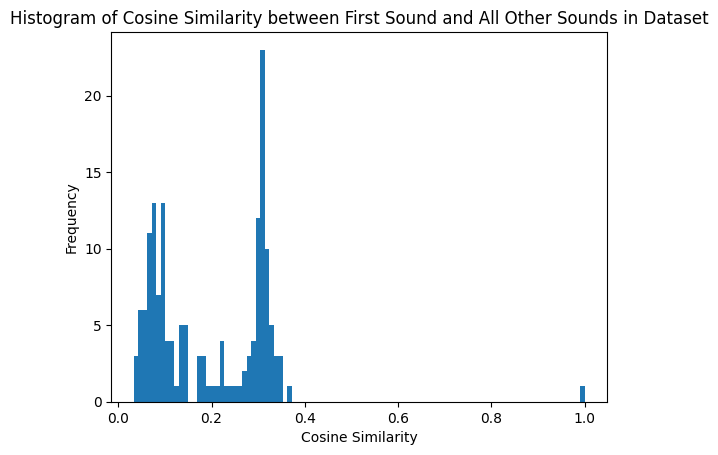

In [12]:
def cosine_similarity(vec1, vec2):
    """ Determines the cosine similarity between two vectors """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Creates histogram of Cosine Similarity between First Sound and All Other Sounds in Dataset

hist_list = []
for i in range(len(binary_vec_list)):
    comp = binary_vec_list[0]
    hist_list.append(cosine_similarity(comp,binary_vec_list[i]))
    
plt.hist(hist_list, bins=100)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity between First Sound and All Other Sounds in Dataset')
plt.show()

In [13]:
# Unused in SimHash implementation

def binary_jaccard_similarity(vec1, vec2):
    """ Defines the Jaccard Similarity between two binary vectors """
    "computes the jaccard similarity for two binary vectors"
    intersection = sum([i == 1 and j == 1 for i, j in zip(vec1, vec2)])
    union = sum([i == 1 or j == 1 for i, j in zip(vec1, vec2)])

    return intersection / union

In [14]:
def calculate_all_cosine_sims(final_hash):
    # Return the cosine similarity for all pairs of similar binary vectors
    similarities = {}
    for vec_idx, similar_vec_indices in final_hash.items():
        for i in range(len(similar_vec_indices)):
            for j in range(i+1, len(similar_vec_indices)):
                idx1, idx2 = list(similar_vec_indices)[i], list(similar_vec_indices)[j]
                vec1, vec2 = binary_vec_list[idx1], binary_vec_list[idx2]
                nm1, nm2 = sound_name_list[idx1], sound_name_list[idx2]
                
                if (nm1, nm2) in similarities or (nm2, nm1) in similarities:
                    continue
                similarity = cosine_similarity(vec1, vec2)

                # Only appends names that have above 0.5 cosine similarity
                if similarity > 0.5:
                    similarities[(nm1, nm2)] = similarity
    return similarities

cos = calculate_all_cosine_sims(final_hash)

In [15]:
cos

{('Clean Chant.wav', 'My Fav Chant.wav'): 1.0,
 ('Basic Trap Clap .wav', 'Go To Yeat Clap 1.wav'): 0.5693484,
 ('YeatxKan Hat 3.wav', 'YeatxKan Hat 4.wav'): 0.5872212,
 ('Go To Snare 3.wav', 'Go To Snare 4.wav'): 0.5597797,
 ('Go To Snare 3.wav', 'Uh Huh Snare.wav'): 0.5346267,
 ('Go To Snare 4.wav', 'Uh Huh Snare.wav'): 0.6612502,
 ('High Up There Snare.wav', 'Jackpot Snare.wav'): 0.9999999,
 ('Click Hat.wav', 'YeatxKan Hat 3.wav'): 0.5318401,
 ('Click Hat.wav', 'YeatxKan Hat 4.wav'): 0.5007596}